**NOTE:** For all questions in this notebook, include your answers in the write pdf submission. Do **not** submit the colab.

# Homework 2

We will use the CIFAR-100 in this notebook, which has **100** classes. Unlike homework 1, we will instead use CNN models to investigate some interesting aspects of training deep models. Moreover, we will use standard PyTorch `nn.Module`s and `optim.Optimizer`s.

<h2>CIFAR-100</h2>

CIFAR-100  is a image classification dataset.
+ Each data sample is an RGB $32\times32$ real image. A raw loaded image $\in \mathbb{R}^{3 \times 32 \times 32}$.
+ Each image is associated with a label $\in \{0,1,2,\dots, 99\}$.


Our goal is to train a neural network classifier that takes such $3\times32\times32$ images and predict a label $\in \{0, 1, 2, \dots, 99\}$.

In [ ]:
# install dependencies

!pip install torch torchvision

You should run on GPU-enabled colab server (should be default for this notebook).

In [ ]:
%matplotlib inline

from typing import *

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dataclasses
from tqdm.auto import tqdm

import torchvision
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
assert torch.cuda.is_available(), "Should use GPU-enabled colab"

device = torch.device('cuda:0')  # we will train with CUDA!

# Dataset

Let's reuse the homework 1 augmented dataset code, but now modified to work on **CIFAR-100**. Code is hidden in the cell below, but make sure to still run it.

100%|██████████| 169001437/169001437 [00:03<00:00, 42657218.50it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Training set size: 50000
Validation set size: 10000
CIFAR-100 classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sun

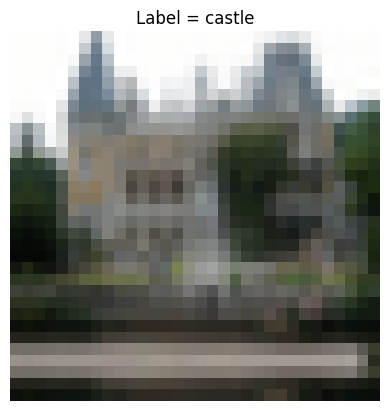

In [ ]:
#@title
%matplotlib inline

import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def get_datasets(train_transforms=(), val_transforms=()):
    r"""
    Returns the CIFAR-100 training and validation datasets with corresponding
    transforms.

    `*_transforms` represent optional transformations, e.g., conversion to
    PyTorch tensors, preprocessing, etc.
    """
    train_set = torchvision.datasets.CIFAR100(
        './data', train=True, download=True,
        transform=torchvision.transforms.Compose(train_transforms))
    val_set = torchvision.datasets.CIFAR100(
        './data', train=False, download=True,
        transform=torchvision.transforms.Compose(val_transforms))
    return train_set, val_set


cifar100_mean = torch.as_tensor([0.5071, 0.4865, 0.4409])
cifar100_std = torch.as_tensor([0.2673, 0.2564, 0.2762])

train_transforms = [
    torchvision.transforms.RandomCrop(32, padding=3, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=cifar100_mean, std=cifar100_std),
]

val_transforms = [
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=cifar100_mean, std=cifar100_std),
]

train_set, val_set = get_datasets(train_transforms, val_transforms)

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")

class_names = train_set.classes
print(f'CIFAR-100 classes: {class_names}')

def visualize_tensor_data(data: torch.Tensor, label: int):
    # Data is a tensor of shape [C, W, H]  (C is the channel dimension, 3 for RGB)
    # Put channel at last
    data = data.permute(1, 2, 0)
    # Un-normalize
    data = data * cifar100_std + cifar100_mean

    plt.imshow(data)
    plt.axis('off')
    plt.title(f'Label = {class_names[label]}')

data, label = train_set[13]
visualize_tensor_data(data, label)


## Network Definition

**Question 5**: Implement the following function that creates the specified CNN networks. Read through the docstring and make sure that your implementation behaves as required. Afterwards, print the outputs of
+ `make_cnn(100, 'tanh', num_conv_layers=5, num_fc_layers=4)`
+ `make_cnn(3, 'none', num_conv_layers=3, num_fc_layers=2)`

Add both your implementation and outputs to the writeup.

---

Links you may find useful:
+ `none` activation: https://pytorch.org/docs/stable/generated/torch.nn.Identity.html?highlight=identity#torch.nn.Identity
+ Chaining layers: https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html?highlight=sequential#torch.nn.Sequential
+ Reshaping image-like tensors to vectors: https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten

(You are not required to use these classes)

In [ ]:
def make_mlp(num_inputs: int, num_outputs: int, activation: str, hidden_sizes: int = [128]) -> nn.Module:

    if activation == 'relu':
        act_cls = nn.ReLU
    elif activation == 'tanh':
        act_cls = nn.Tanh
    elif activation == 'none':
        act_cls = nn.Identity
    else:
        raise ValueError(f'Unexpected activation={repr(activation)}')

    net = [nn.Flatten(),
           nn.Linear(num_inputs, hidden_sizes[0]),
           act_cls()]

    for i in range(1, len(hidden_sizes)):
      net.extend([nn.Linear(hidden_sizes[i-1], hidden_sizes[i]),
                  act_cls()])

    net.extend([nn.Linear(hidden_sizes[-1], num_outputs)])

    return nn.Sequential(*net)

In [ ]:
from IPython.core.interactiveshell import oinspect
def make_cnn(num_outputs: int, activation: str, num_conv_layers: int = 4, num_fc_layers: int = 2) -> nn.Module:
    r'''
    Returns a PyTorch module representing a CNN network that takes in image-like input with shape [3, 32, 32].

    Args:
        num_outputs (int): size of the final output layer. E.g., if the network is a classifier, this is usually #classes.
        activation (str): activation functions between conv/linear layers. Supported choices are ['relu', 'tanh', 'none'] (always strings).
            For 'none', no activation function is applied, and the previous conv/linear output is directly fed into the next conv/linear.
        num_conv_layers (int): number of conv layers in CNN. This should be >= 3 and <= 5.
            First conv layer should always use 5x5 kernels, mapping 3-channel data to 12-channel data, with **reflect** padding=2 and no striding.
            Subsequent conv layers should always use 3x3 kernels, mapping to 64-channel data, with zeros (default) padding=1 and strides=2.
        num_fc_layers (int): number of fc/linear layers after the convolutional part. This should be >= 2.
            For all but the last fc layer, it should output 128-dimensional vectors.

    Returns:
        (nn.Module) The CNN network of desired tructure.

    If an unexpected input is given, this will raise a ValueError. (You can assume that arguments are of correct types.)
    '''

    # FIXME
    if activation == 'relu':
        act_cls = nn.ReLU
    elif activation == 'tanh':
        act_cls = nn.Tanh
    elif activation == 'none':
        act_cls = nn.Identity
    else:
        raise ValueError(f'Unexpected activation={repr(activation)}')

    if num_conv_layers < 3 or num_conv_layers > 5:
      raise ValueError(f"Unexpected number of conv layers={repr(num_conv_layers)}")

    if num_fc_layers < 2:
      raise ValueError(f"Unexpected number of fc/linear layers={repr(num_fc_layers)}")

    cnn = [nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, padding=2, padding_mode='reflect', stride=1),
           act_cls()]

    for i in range(1, num_conv_layers):
      cnn.extend([nn.Conv2d(in_channels=12 if i == 1 else 64, out_channels=64, kernel_size=3, padding=1, padding_mode='zeros', stride=2),
                  act_cls()])

    cnn.extend([nn.Flatten(),
                nn.Linear(in_features=64 * (32 // (2 ** (num_conv_layers - 1)))**2, out_features=128),
                act_cls()])

    for j in range(num_fc_layers-2):
      cnn.extend([nn.Linear(in_features=128, out_features=128),
                  act_cls()])

    cnn.extend([nn.Linear(in_features=128, out_features=num_outputs)])

    return nn.Sequential(*cnn)

In [ ]:
print('num_outputs=100, tanh, hidden_sizes=[128, 120]')
print(make_mlp(10, 100, 'tanh', hidden_sizes=[128, 120]))
print()
print('num_outputs=100, tanh, num_conv_layers=5, num_fc_layers=4:')
print(make_cnn(100, 'tanh', num_conv_layers=5, num_fc_layers=4))
print()
print('num_outputs=3, no activation, num_conv_layers=3, num_fc_layers=2:')
print(make_cnn(3, 'none', num_conv_layers=3, num_fc_layers=2))

num_outputs=100, tanh, hidden_sizes=[128, 120]
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=10, out_features=128, bias=True)
  (2): Tanh()
  (3): Linear(in_features=128, out_features=120, bias=True)
  (4): Tanh()
  (5): Linear(in_features=120, out_features=100, bias=True)
)

num_outputs=100, tanh, num_conv_layers=5, num_fc_layers=4:
Sequential(
  (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=reflect)
  (1): Tanh()
  (2): Conv2d(12, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): Tanh()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Tanh()
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): Tanh()
  (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): Tanh()
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=256, out_features=128, bias=True)
  (12): Tanh()
  (13): Linear(in_features=128, out_features=12

## Training loop

**Question 6**: Implement the following training and evaluate functions according to docstring. Complete the `FIXME`s in `train_epoch`, `evaluate`, and `train`. Attach your code to PDF.

---

Links you may find useful:
+ Classification loss: https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html?highlight=cross_entropy#torch.nn.functional.cross_entropy
+ Learning rate adjustment: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

(You are not required to use these classes)

In [ ]:
def train_epoch(epoch: int, model: nn.Module, train_loader: torch.utils.data.DataLoader, optim: torch.optim.Optimizer):
    r"""
    Trains `model` on `train_loader` for cross entropy loss for one epoch.

    Args:
        epoch (int): the current epoch number (i.e., number of epochs done before this one).
        model (nn.Module): our network (created using `make_cnn`).
        train_loader (DataLoader): a DataLoader that yields (batched_images, batched_target_class_indices) when iterated.
        optim (Optimizer): optimizer object that is created with `model` parameters and should be used for updating `model` in this function.

    Returns:
        (List[float]) the losses computed at each iteration as a list of *Python* numbers.

    NOTE:
      + Remember to clear previously computed gradient at beginning of each iteration.
      + Convert loss values to python floats (e.g., via `.item()`) before adding to `loss_values`.
    """
    loss_values: List[float] = []

    for data, target in tqdm(train_loader, desc=f'Training @ epoch {epoch}'):
        # FIXME

        # Convert data and target to proper device for training
        data = data.to(device)
        target = target.to(device)

        # Clear previously computed gradient at beginning of each iteration.
        optim.zero_grad()

        # Forward pass the model
        output = model(data)
        loss = F.cross_entropy(model(data), target)

        # Backpropagate

        # Update model parameters
        loss.backward()
        optim.step()

        loss_values.extend([loss.item()])

    return loss_values



@dataclasses.dataclass
class EvaluateResult:
    r"""
    A collection containing everything we need to know about the evaluate results.

    See `evaluate` docstring for meanings of the members of this class
    """
    acc: float  # overall accuracy
    correct_predictions: torch.Tensor  # size |dataset|
    confidence: torch.Tensor  # size |dataset|


@torch.no_grad()
def evaluate(model: nn.Module, loader: torch.utils.data.DataLoader) -> EvaluateResult:
    r"""
    Evaluate a classifier `model` on dataset contained in `loader`.

    For each input, the predicted label is taken as one with highest probability in the distribution given by `model`.

    In addition to compute overall accuracies, we also output
        (1) a boolean Tensor with size |dataset|, showing whether each sample is correctly classified.
        (2) a float32 Tensor with size |dataset|, showing the `model`'s assigned probability for its prediction, called *confidence*.

    Args:
        model (nn.Module): our network (created using `make_cnn`).
        loader (DataLoader): a DataLoader that yields (batched_images, batched_target_class_indices) when iterated.

    Returns:
        (EvaluateResult) Containing overall accuracy, whether each sample is correctly classified, and confidence.
            The tensors should be on **CPU**.
    """
    # FIXME
    correct_predictions_list = []
    confidence_list = []

    for images, target in loader:

      images = images.to(next(model.parameters()).device)
      outputs = model(images)

      # the predicted label is taken as one with highest probability.
      _, predicted_label = torch.max(outputs, 1)

      target = target.cpu()
      predicted_label = predicted_label.cpu()

      # showing whether each sample is correctly classified.
      correct_prediction = (predicted_label == target)

      # showing the `model`'s assigned probability for its prediction
      confidence = torch.max(F.softmax(outputs, dim=1), dim=1)[0].cpu()

      correct_predictions_list.extend([correct_prediction])
      confidence_list.extend([confidence])

    correct_prediction_torch = torch.cat(correct_predictions_list)
    confidence_torch = torch.cat(confidence_list)
    accuracy = correct_prediction_torch.float().mean().item()

    return EvaluateResult(accuracy, correct_prediction_torch, confidence_torch)


@dataclasses.dataclass
class TrainResult:
    r"""
    A collection containing everything we need to know about the training results
    """
    num_epochs: int

    # Training loss (saved at each iteration in `train_epoch`)
    train_losses: List[float]

    # The epochs where we perform evaluation
    eval_epochs: List[int]

    # Training accuracies, computed at each epoch in `eval_epochs`
    train_accs: List[float]

    # Validation accuracies, computed at each epoch in `eval_epochs`
    val_accs: List[float]

    # The last validation evaluation full result
    final_val_eval_result: EvaluateResult = None


def train(model: nn.Module, train_set, val_set, *, num_epochs=60, lr=0.003, train_epoch_fn=train_epoch, **kwargs):
    r"""
    Train `model` on `train_set` for `num_epochs` epochs using **Adam** optimizer and `lr` learning rate
    following a decay schedule by a factor of `0.3` at epochs `[5, 50]`.

    Args:
        model (nn.Module): our network (created using `make_cnn`).
        train_set (Dataset): CIFAR-100 training dataset.
        val_set (Dataset): CIFAR-100 validation dataset. Evaluated every *5* epochs and at the end of training.
        num_epochs (int): number of total training epochs.
        lr (float): initial learning rate.
        train_epoch_fn (Callable): function that trains the model for a single epoch. This is `train_epoch`
            usually, but we will use different choices in later questions.

    Returns:
        (TrainResult)
    """
    # Data loaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=512, shuffle=True)  # Random order for training ("[S]tochastic" in SGD)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=1024, shuffle=False)

    # Our classifier
    print('Model =', model)

    # Create optimizer and lr scheduler
    # FIXME
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[5, 50], gamma=0.3)

    result: TrainResult = TrainResult(num_epochs, train_losses=[], eval_epochs=[], train_accs=[], val_accs=[])
    last_eval_epoch = -float('inf')

    # Iterate through the entire training dataset `num_epochs` times
    for epoch in range(num_epochs):
        if epoch - last_eval_epoch >= 5:
            result.eval_epochs.append(epoch)
            result.train_accs.append(evaluate(model, train_loader).acc)
            result.val_accs.append(evaluate(model, val_loader).acc)
            print(f"Epoch = {epoch:> 2d}    Train acc = {result.train_accs[-1]:.2%}    Val acc = {result.val_accs[-1]:.2%}")
            last_eval_epoch = epoch
        # Train over the entire `train_set` with given `train_epoch_fn` function (i.e., one epoch)
        result.train_losses.extend(train_epoch_fn(epoch, model, train_loader, optim, **kwargs))
        # Evaluate with our `evaluate` function
        print(f"Epoch = {epoch:> 2d}    Train loss = {result.train_losses[-1]:.4f}")

        # Adjust learning rate if needed
        scheduler.step()

    result.eval_epochs.append(num_epochs)
    result.train_accs.append(evaluate(model, train_loader).acc)
    result.final_val_eval_result = evaluate(model, val_loader)
    result.val_accs.append(result.final_val_eval_result.acc)
    print(f"Epoch = {num_epochs:> 2d}    Train acc = {result.train_accs[-1]:.2%}    Val acc = {result.val_accs[-1]:.2%}")

    return result

We provide the following learning curve plotting function (similar to homework 1).

In [ ]:
def learning_curve(result: TrainResult, *, title: str = 'Learning Curve'):
    r"""
    Plot the training loss, training accuracy, and validation accuracy versus
    epochs taken.
    """
    fig, ax_loss = plt.subplots(figsize=(8, 5))
    ax_loss.set_title(title, fontsize=16)
    ax_loss.set_xlabel('Epoch', fontsize=12)

    l_trloss = ax_loss.plot(
        torch.arange(len(result.train_losses)) / len(result.train_losses) * result.num_epochs,
        result.train_losses,
        label='Train loss',
        color='C0',
    )
    ax_loss.set_ylim(0, 4.8)
    ax_loss.set_ylabel('Train loss', color='C0', fontsize=12)
    ax_loss.tick_params(axis='y', labelcolor='C0')

    ax_acc = ax_loss.twinx()
    l_tracc = ax_acc.plot(result.eval_epochs, result.train_accs, label='Train acc', color='C1', linestyle='--')
    if len(result.val_accs):
        l_valacc = ax_acc.plot(result.eval_epochs, result.val_accs, label='Val acc', color='C1')
    else:
        l_valacc = []
    ax_acc.set_ylim(0, 1)
    ax_acc.set_ylabel('Accuracies', color='C1', fontsize=12)
    ax_acc.tick_params(axis='y', labelcolor='C1')

    lines = l_trloss + l_tracc + l_valacc
    ax_loss.legend(lines, [l.get_label() for l in lines], loc='upper left', fontsize=13)

Model = Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=128, bias=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=100, bias=True)
)
Epoch =  0    Train acc = 1.05%    Val acc = 1.17%


Training @ epoch 0:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  0    Train loss = 3.7208


Training @ epoch 1:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  1    Train loss = 3.4863


Training @ epoch 2:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  2    Train loss = 3.6293


Training @ epoch 3:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  3    Train loss = 3.2270


Training @ epoch 4:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  4    Train loss = 3.3254
Epoch =  5    Train acc = 20.53%    Val acc = 20.15%


Training @ epoch 5:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  5    Train loss = 3.2300


Training @ epoch 6:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  6    Train loss = 3.1347


Training @ epoch 7:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  7    Train loss = 3.0983


Training @ epoch 8:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  8    Train loss = 3.0316


Training @ epoch 9:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  9    Train loss = 3.0997
Epoch =  10    Train acc = 25.72%    Val acc = 23.66%


Training @ epoch 10:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  10    Train loss = 2.9541


Training @ epoch 11:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  11    Train loss = 2.9959


Training @ epoch 12:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  12    Train loss = 3.0346


Training @ epoch 13:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  13    Train loss = 2.9679


Training @ epoch 14:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  14    Train loss = 2.9020
Epoch =  15    Train acc = 27.57%    Val acc = 25.44%


Training @ epoch 15:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  15    Train loss = 2.8185


Training @ epoch 16:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  16    Train loss = 2.9602


Training @ epoch 17:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  17    Train loss = 3.0278


Training @ epoch 18:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  18    Train loss = 2.8297


Training @ epoch 19:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  19    Train loss = 2.9470
Epoch =  20    Train acc = 28.56%    Val acc = 25.84%


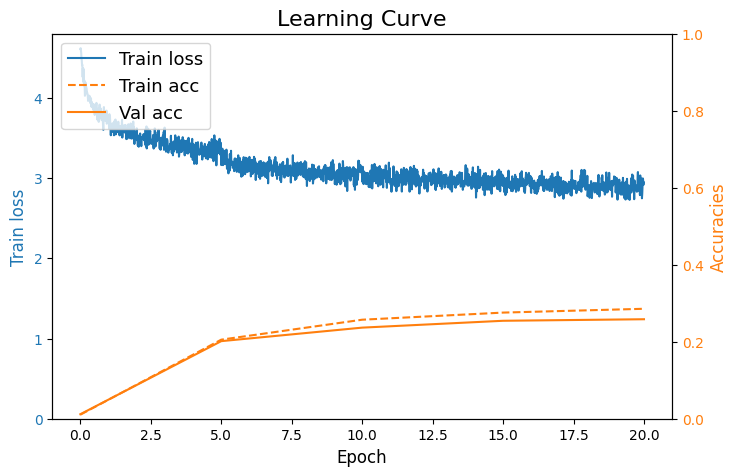

In [ ]:
# Create a MLP 128 width, 3 depth on the GPU, train it, and plot learning curves.
mlp1 = make_mlp(num_inputs=3*32*32, num_outputs=100, activation='relu', hidden_sizes=[128, 128, 128])
mlp1.to(device)

# Train the model
result1 = train(mlp1, train_set, val_set, num_epochs=20)
learning_curve(result1)
plt.show()

Model = Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=128, bias=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=128, bias=True)
  (12): ReLU()
  (13): Linear(in_features=128, out_features=128, bias=True)
  (14): ReLU()
  (15): Linear(in_features=128, out_features=100, bias=True)
)
Epoch =  0    Train acc = 1.00%    Val acc = 1.00%


Training @ epoch 0:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  0    Train loss = 4.1623


Training @ epoch 1:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  1    Train loss = 3.7372


Training @ epoch 2:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  2    Train loss = 3.7711


Training @ epoch 3:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  3    Train loss = 3.5060


Training @ epoch 4:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  4    Train loss = 3.6367
Epoch =  5    Train acc = 15.42%    Val acc = 15.45%


Training @ epoch 5:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  5    Train loss = 3.2638


Training @ epoch 6:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  6    Train loss = 3.2199


Training @ epoch 7:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  7    Train loss = 3.4303


Training @ epoch 8:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  8    Train loss = 3.3387


Training @ epoch 9:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  9    Train loss = 3.3256
Epoch =  10    Train acc = 20.17%    Val acc = 20.19%


Training @ epoch 10:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  10    Train loss = 3.2669


Training @ epoch 11:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  11    Train loss = 3.1424


Training @ epoch 12:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  12    Train loss = 3.2193


Training @ epoch 13:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  13    Train loss = 3.1919


Training @ epoch 14:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  14    Train loss = 3.3197
Epoch =  15    Train acc = 22.28%    Val acc = 21.76%


Training @ epoch 15:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  15    Train loss = 3.2606


Training @ epoch 16:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  16    Train loss = 3.2007


Training @ epoch 17:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  17    Train loss = 3.2063


Training @ epoch 18:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  18    Train loss = 3.1737


Training @ epoch 19:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  19    Train loss = 3.0782
Epoch =  20    Train acc = 24.03%    Val acc = 22.78%


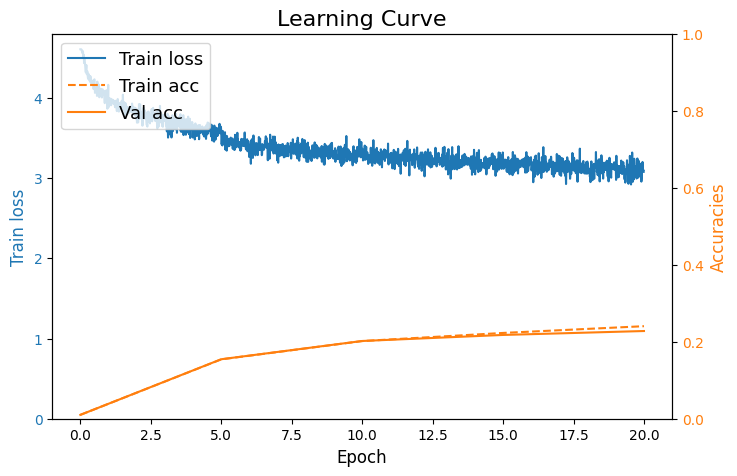

In [ ]:
# Create a MLP 128 width, 7 depth on the GPU, train it, and plot learning curves.
mlp2 = make_mlp(num_inputs=3*32*32, num_outputs=100, activation='relu', hidden_sizes=[128, 128, 128, 128, 128, 128, 128])
mlp2.to(device)

# Train the model
result2 = train(mlp2, train_set, val_set, num_epochs=20)
learning_curve(result2)
plt.show()

Model = Sequential(
  (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=reflect)
  (1): ReLU()
  (2): Conv2d(12, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1024, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=128, bias=True)
  (12): ReLU()
  (13): Linear(in_features=128, out_features=100, bias=True)
)
Epoch =  0    Train acc = 1.00%    Val acc = 1.00%


Training @ epoch 0:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  0    Train loss = 3.7693


Training @ epoch 1:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  1    Train loss = 3.4958


Training @ epoch 2:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  2    Train loss = 3.3613


Training @ epoch 3:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  3    Train loss = 3.2673


Training @ epoch 4:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  4    Train loss = 3.0095
Epoch =  5    Train acc = 25.85%    Val acc = 26.31%


Training @ epoch 5:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  5    Train loss = 2.4821


Training @ epoch 6:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  6    Train loss = 2.7507


Training @ epoch 7:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  7    Train loss = 2.7758


Training @ epoch 8:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  8    Train loss = 2.5366


Training @ epoch 9:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  9    Train loss = 2.6517
Epoch =  10    Train acc = 34.07%    Val acc = 32.73%


Training @ epoch 10:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  10    Train loss = 2.6025


Training @ epoch 11:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  11    Train loss = 2.4617


Training @ epoch 12:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  12    Train loss = 2.6244


Training @ epoch 13:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  13    Train loss = 2.4051


Training @ epoch 14:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  14    Train loss = 2.2889
Epoch =  15    Train acc = 38.13%    Val acc = 35.89%


Training @ epoch 15:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  15    Train loss = 2.4394


Training @ epoch 16:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  16    Train loss = 2.3616


Training @ epoch 17:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  17    Train loss = 2.4353


Training @ epoch 18:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  18    Train loss = 2.3314


Training @ epoch 19:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  19    Train loss = 2.2737
Epoch =  20    Train acc = 41.03%    Val acc = 38.72%


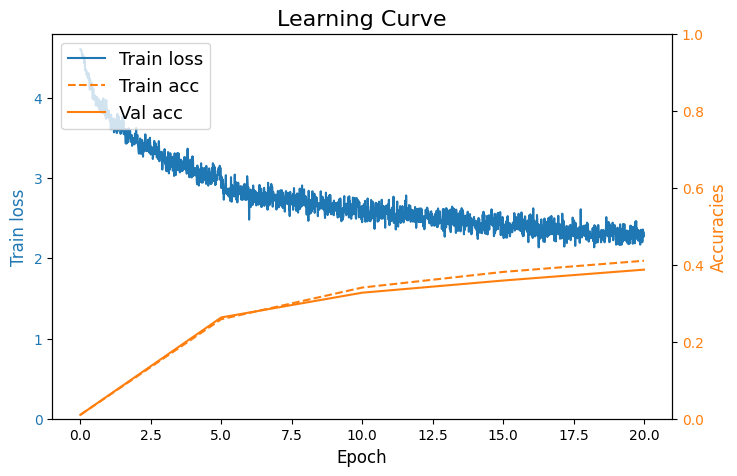

In [ ]:
# Create a CNN 4 convolutional layers, 3 MLP layers on the GPU, train it, and plot learning curves.
cnn = make_cnn(num_outputs=100, activation= 'relu', num_conv_layers=4, num_fc_layers=3)
cnn.to(device)

# Train the model
result3 = train(cnn, train_set, val_set, num_epochs=20)
learning_curve(result3)
plt.show()